# Create artifact from time series dataframe
Gets a .tsf or .csv with a time serie, convert int to np.dataframe and loads it to weights and biases (W&B)

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection
### VsCode update patch
Initial notebook setup when using VSCode

In [1]:
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

### Debugging variables
- `print_flag`. If `True` it adds debbuging messages in those functions that allows so (eg. `get_enc_embeddings`)
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.

In [2]:
print_flag = True
reset_kernel=False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [3]:
import utils.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0
8 - eamonn_penguins
9 - insects_0
10 - cars


In [4]:
pre_configured_case = True
case_id = 8
frequency_factor = 1
frequency_factor_change_alias = True

## Main code


In [5]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Path and Artiffact configurattions
This notebook gets configuration from `config\base.yaml` and `config\01-dataset_artifact.yaml`

In [6]:
base_path = Path.home()

In [7]:
config = cfg_.get_artifact_config_sd2a(print_flag = False)
if pre_configured_case: 
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        print_flag = print_flag, 
        both = print_flag, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )

Selecting  eamonn_penguins
artifact_name: Monash-Australian_electricity_demand -> penguins
date_offset: None
wandb_artifacts_path: ./data/wandb_artifacts
start_date: None
csv_config: {}
test_split: None
resampling_freq: None
range_testing: None
date_format: %Y-%m-%d %H:%M:%S
use_wandb: True
missing_values_constant: None
data_cols: [0] -> []
missing_values_technique: None
time_col: None
joining_train_test: False
range_training: None
normalize_training: False
data_fpath: ~/data/australian_electricity_demand_dataset.tsf -> ~/data/MP_first_test_penguin_sample.csv
freq: 1h -> 1s


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

#### Check file content (if wanted)

In [8]:
if print_flag:
    fpath=os.path.expanduser(config.data_fpath)
    print(fpath)
    try: 
        with open(fpath, 'r') as file:
            for _ in range(13):
                line = file.readline()
                print(line, end='')
        data, _, _, _, _ = convert_tsf_to_dataframe(fpath)
        print("Timestamp", data.start_timestamp)
    except Exception as e:
        print("Error while converting file. Maybe not a tsf: ", e)

/home/macu/data/MP_first_test_penguin_sample.csv
0
0.253906
0.259033
0.269287
0.27124
0.265137
0.26001
0.246826
0.239746
0.231445
0.230469
0.243652
0.248779
Error while converting file. Maybe not a tsf:  Missing attribute section. Attribute section must come before data.


#### Extract data

In [9]:
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')


In [10]:
if print_flag:
    print(f'File loaded successfully')
    print(df.shape)
    display(df.head())

File loaded successfully
(109842, 1)


,0
0,0.253906
1,0.259033
2,0.269287
3,0.271240
4,0.265137


In [11]:
df

,0
0,0.253906
1,0.259033
2,0.269287
3,0.271240
4,0.265137
...,...
109837,0.070312
109838,0.053955
109839,0.055908
109840,0.064209


#### Set the time column (if any) as index

In [12]:
if config.time_col is not None:
    if print_flag: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if print_flag: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if print_flag: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if print_flag: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if print_flag: display(df.head())

,0
0,0.253906
1,0.259033
2,0.269287
3,0.271240
4,0.265137


#### Set dataframe frequency

In [13]:
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if print_flag: print(df.index.freq)

<Second>


#### Select only the needed variables

In [14]:
# Subset of variables
if config.data_cols:
    if print_flag: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if print_flag: print(f'Num. variables: {len(df.columns)}')

Num. variables: 1


#### Ensure data integrity

In [15]:
#Duplicated rows
if print_flag: print("df shape before dropping duplicates", df.shape)
df.drop_duplicates()
if print_flag: print("df shape after dropping duplicates", df.shape)
# Verificar si hay duplicados en el índice del dataframe
if df.index.duplicated().any():
    raise ValueError("Duplicated index names")

df shape before dropping duplicates (109842, 1)
df shape after dropping duplicates (109842, 1)


In [16]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

#### Show time series plot

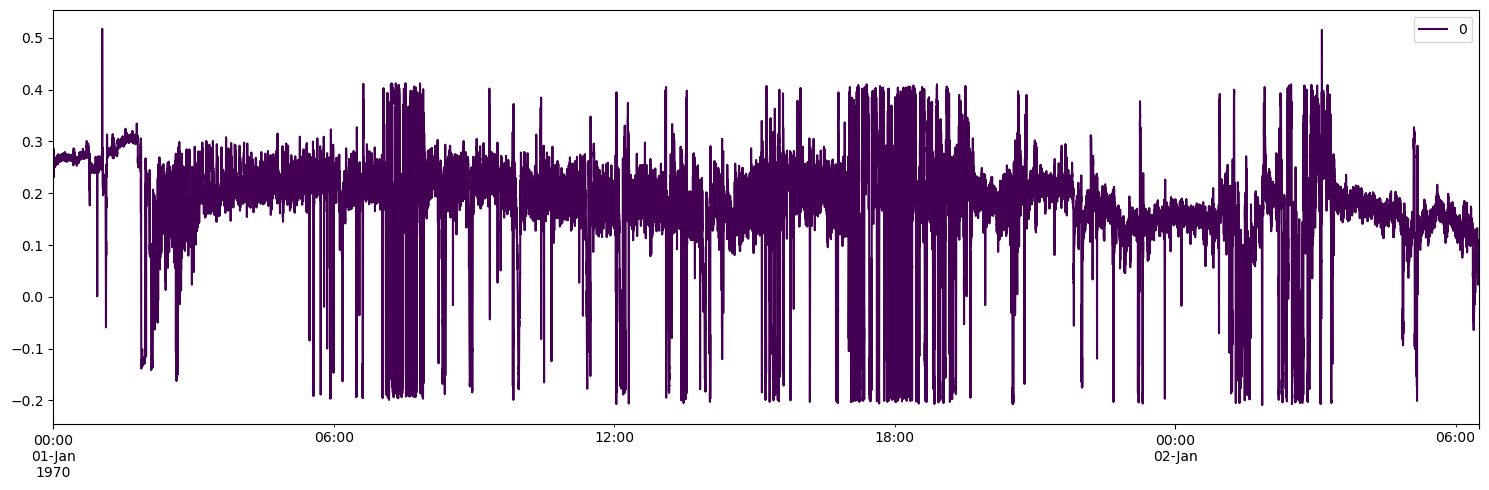

None

In [17]:
show_time_serie_flag = True
if show_time_serie_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

### Add Lag features

In [18]:
df.head(13)

,0
1970-01-01 00:00:00,0.253906
1970-01-01 00:00:01,0.259033
1970-01-01 00:00:02,0.269287
1970-01-01 00:00:03,0.271240
1970-01-01 00:00:04,0.265137
1970-01-01 00:00:05,0.260010
1970-01-01 00:00:06,0.246826
1970-01-01 00:00:07,0.239746
1970-01-01 00:00:08,0.231445
1970-01-01 00:00:09,0.230469


In [31]:
from tsai.data.core import TSTensor
from tsai.data.preprocessing  import TSRollingMean
import torch 

tensor([[[   nan, 0.2919,    nan,    nan,    nan, 0.2118, 0.5962, 0.1666],
         [   nan, 0.1338, 0.1474,    nan,    nan, 0.1960, 0.0829, 0.3443],
         [0.4048, 0.2908,    nan,    nan, 0.4571,    nan, 0.0562,    nan]]])
torch.Size([1, 3, 8])
torch.Size([1, 5, 8])
tensor([[[0.2919, 0.2919, 0.2919, 0.2919, 0.2919, 0.2118, 0.5962, 0.1666],
         [   nan, 0.1338, 0.1474,    nan,    nan, 0.1960, 0.0829, 0.3443],
         [0.4048, 0.2908, 0.2908, 0.2908, 0.4571, 0.4571, 0.0562, 0.0562],
         [0.2919, 0.2919, 0.2919, 0.2919, 0.2919, 0.2652, 0.3666, 0.3249],
         [0.4048, 0.3478, 0.3288, 0.2908, 0.3462, 0.4016, 0.3234, 0.1898]]])


In [ ]:
def add_lagged_features(df, total_extra_features = 12, save_index = True):
    # reframe as supervised learning
    if save_index:
        df_lag = pd.DataFrame(index=df.index)
    else:
        df_lag = pd.DataFrame()
    for i in range(total_extra_features,0,-1):
     df_lag['t-'+str(i)] = df.shift(i).values[:,0]
    df_lag['t'] = df.values[:,0]
    return df_lag

In [ ]:
df_lag = add_lagged_features(df, 12)
print(df_lag.head(13))

### Data Transformation

__Handle Missing Values, Resample and Normalize__

> In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied.
> 
> This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

#### Training data

##### Build dataframe

In [ ]:
def build_train_df(config, df, print_flag = False): 
    rg = config.range_training
    if isinstance(rg, list):
        rg_training = rg
    
    elif isinstance(rg, dict):
        rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
    elif config.test_split:
        rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

    else:
        rg_training = None
        
    df_training = df[df.index.isin(rg_training)] if rg_training is not None else df
    return df_training, rg_training    

In [ ]:
df_training, rg_training = build_train_df(config, df_lag)

In [ ]:
df_training.head()

##### Build training artifact

In [ ]:
training_artifact = TSArtifact.from_df(
    df_training, 
    name=config.artifact_name, 
    missing_values_technique=config.missing_values_technique,
    resampling_freq=config.resampling_freq, 
    normalize=config.normalize_training, 
    path=str(Path.home()/config.wandb_artifacts_path)
)
if print_flag: display(training_artifact.metadata)

In [ ]:
#Debugging 
if df_training.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Testing data

##### Build dataframe & artifact

In [ ]:
def build_test_df(config, df, print_flag = False): 
    # Testing data
    rg = config.range_testing
    df_testing = pd.DataFrame()
    if rg or config.test_split:
    
        if isinstance(rg, list):
            rg_testing = rg

        elif isinstance(rg, dict):
            rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

        elif config.test_split:
            rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]
        else:
            rg_testing = None
        df_testing = df[df.index.isin(rg_testing)]
        testing_artifact = TSArtifact.from_df(
            df_testing,
            name=config.artifact_name, 
            missing_values_technique=config.missing_values_technique,
            resampling_freq=config.resampling_freq, 
            normalize=False,
            path=str(Path.home()/config.wandb_artifacts_path)
        )
        display(testing_artifact.metadata)
        if df_testing.index.duplicated().any():
            print("Duplicated values in dataframe index.")
        else:
            print("No duplicated values in dataframe index")
    else:
        if print_flag: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
        testing_artifact = None
    return df_testing, testing_artifact

In [ ]:
df_testing, testing_artifact = build_test_df(config, df_lag, False)

#### Training + Testing data

##### Build dataframe & artifact

In [ ]:
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(
        df_train_test,
        name=config.artifact_name, 
        missing_values_technique=config.missing_values_technique,
        resampling_freq=config.resampling_freq, 
        normalize=False,
        path=str(Path.home()/config.wandb_artifacts_path)
    )
    if df_train_test.index.duplicated().any():
        print("Duplicated values in dataframe index.")
    else:
        print("No duplicated values in dataframe index.")
    display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

> 
Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two
> 
> <span style="color:red"> TODO: Modify config.ipynb so it gets wandb config from base.yml </span>.

In [ ]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

In [ ]:
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

In [ ]:
run.finish()

In [ ]:
from dvats.imports import beep
print("Execution ended")
beep(1)

In [ ]:
if reset_kernel:
    import os
    os._exit(00)